In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import bisect
import seaborn as sns
pd.options.display.max_columns = 99
pd.options.display.max_rows = 199

In [15]:
nrc = pd.read_csv("../data/nrc_weekly_cat.csv")
nrc["timestep"] = pd.to_datetime(nrc["timestep"])
nrc = nrc.drop("Unnamed: 0", axis=1)
econ_master = pd.read_csv("../data/Econ/EconOriginal/econ_master.csv")
econ_master = econ_master.drop("Unnamed: 0", axis=1)
econ_master["DATE"] = pd.to_datetime(econ_master["DATE"])

In [16]:
nrc.head()

,timestep,trust_prop,anger_prop,fear_prop,negative_prop,sadness_prop,surprise_prop,positive_prop,disgust_prop,joy_prop,anticipation_prop,trust_cnts,anger_cnts,fear_cnts,negative_cnts,sadness_cnts,surprise_cnts,positive_cnts,disgust_cnts,joy_cnts,anticipation_cnts,num_words,song_counts,WeekID,trust_prop_detrended,anger_prop_detrended,fear_prop_detrended,negative_prop_detrended,sadness_prop_detrended,surprise_prop_detrended,positive_prop_detrended,disgust_prop_detrended,joy_prop_detrended,anticipation_prop_detrended
0,1958-08-02,0.411349,0.118392,0.183048,0.325812,0.202441,0.143044,0.599196,0.100254,0.455321,0.266046,697.333333,193.666667,319.666667,540.000000,332.000000,265.666667,1098.666667,160.833333,791.000000,459.666667,1797.833333,75,-596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1958-08-09,0.401904,0.111387,0.175890,0.319436,0.206642,0.137407,0.592637,0.093282,0.433834,0.261371,725.666667,206.666667,347.666667,587.666667,376.000000,277.000000,1140.333333,167.166667,805.666667,494.000000,1916.833333,79,-595,-0.009445,-0.007005,-0.007158,-0.006376,0.004201,-0.005637,-0.006560,-0.006972,-0.021487,-0.004675
2,1958-08-16,0.382215,0.103377,0.155576,0.290782,0.184506,0.139163,0.616364,0.074417,0.447688,0.286152,625.666667,173.666667,286.666667,485.666667,308.000000,243.000000,1073.333333,121.166667,755.666667,468.000000,1718.833333,70,-594,-0.019690,-0.008010,-0.020315,-0.028654,-0.022136,0.001755,0.023728,-0.018865,0.013854,0.024781
3,1958-08-23,0.387391,0.093500,0.154120,0.296855,0.188361,0.138984,0.617310,0.071227,0.443808,0.278188,641.666667,159.666667,287.666667,509.166667,321.000000,249.000000,1095.333333,124.166667,760.666667,473.500000,1762.333333,71,-593,0.005176,-0.009877,-0.001456,0.006073,0.003854,-0.000179,0.000946,-0.003190,-0.003880,-0.007964
4,1958-08-30,0.393765,0.092171,0.154056,0.281122,0.187542,0.137868,0.619837,0.061882,0.451476,0.271352,667.333333,155.666667,268.833333,460.500000,298.666667,236.000000,1077.500000,111.833333,778.333333,450.833333,1701.833333,65,-592,0.006375,-0.001330,-0.000064,-0.015733,-0.000819,-0.001116,0.002526,-0.009345,0.007668,-0.006836


In [17]:
econ_master.head()

,DATE,MonthID,S&P,S&P_detrended,Unemp,Unemp_detrended,Food&Beverage,Food&Beverage_detrended,GDP,GDP_detrended,Income,Income_detrended,LoanRate,LoanRate_detrended
0,1958-01-01,1958.000000,41.700001,NaN,5.8,NaN,NaN,NaN,2906.274,-77.453,NaN,NaN,NaN,NaN
1,1958-02-01,1958.083333,40.840000,-0.860001,6.4,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1958-03-01,1958.166667,42.099998,1.259998,6.7,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1958-04-01,1958.250000,43.439999,1.340001,7.4,0.7,NaN,NaN,2925.379,19.105,NaN,NaN,NaN,NaN
4,1958-05-01,1958.333333,44.090000,0.650001,7.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
week_datetime = [pd.to_datetime(i * 604800 * 10**9) for i in range(-2000, 3000)]
week_ids = list(range(-2000, 3000))

In [19]:
grab_week_id = lambda x: week_ids[bisect.bisect_right(week_datetime, x)]-1 if (x - pd.to_datetime(0)).days < 0 \
    else week_ids[bisect.bisect_left(week_datetime, x)]

In [20]:
nrc["WeekID"] = [grab_week_id(i) for i in nrc["timestep"]]
[np.min(nrc["WeekID"]), np.max(nrc["WeekID"])]

[-596, 2557]

In [21]:
econ_master["WeekID"] = [grab_week_id(i) for i in econ_master["DATE"]]

In [22]:
nrc_econ = nrc.merge(econ_master, left_on="WeekID", right_on="WeekID", how='left').reset_index(drop=True)
nrc_econ.head()

,timestep,trust_prop,anger_prop,fear_prop,negative_prop,sadness_prop,surprise_prop,positive_prop,disgust_prop,joy_prop,anticipation_prop,trust_cnts,anger_cnts,fear_cnts,negative_cnts,sadness_cnts,surprise_cnts,positive_cnts,disgust_cnts,joy_cnts,anticipation_cnts,num_words,song_counts,WeekID,trust_prop_detrended,anger_prop_detrended,fear_prop_detrended,negative_prop_detrended,sadness_prop_detrended,surprise_prop_detrended,positive_prop_detrended,disgust_prop_detrended,joy_prop_detrended,anticipation_prop_detrended,DATE,MonthID,S&P,S&P_detrended,Unemp,Unemp_detrended,Food&Beverage,Food&Beverage_detrended,GDP,GDP_detrended,Income,Income_detrended,LoanRate,LoanRate_detrended
0,1958-08-02,0.411349,0.118392,0.183048,0.325812,0.202441,0.143044,0.599196,0.100254,0.455321,0.266046,697.333333,193.666667,319.666667,540.000000,332.000000,265.666667,1098.666667,160.833333,791.000000,459.666667,1797.833333,75,-596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1958-08-01,1958.583333,47.750000,0.560001,7.4,-0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1958-08-09,0.401904,0.111387,0.175890,0.319436,0.206642,0.137407,0.592637,0.093282,0.433834,0.261371,725.666667,206.666667,347.666667,587.666667,376.000000,277.000000,1140.333333,167.166667,805.666667,494.000000,1916.833333,79,-595,-0.009445,-0.007005,-0.007158,-0.006376,0.004201,-0.005637,-0.006560,-0.006972,-0.021487,-0.004675,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1958-08-16,0.382215,0.103377,0.155576,0.290782,0.184506,0.139163,0.616364,0.074417,0.447688,0.286152,625.666667,173.666667,286.666667,485.666667,308.000000,243.000000,1073.333333,121.166667,755.666667,468.000000,1718.833333,70,-594,-0.019690,-0.008010,-0.020315,-0.028654,-0.022136,0.001755,0.023728,-0.018865,0.013854,0.024781,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1958-08-23,0.387391,0.093500,0.154120,0.296855,0.188361,0.138984,0.617310,0.071227,0.443808,0.278188,641.666667,159.666667,287.666667,509.166667,321.000000,249.000000,1095.333333,124.166667,760.666667,473.500000,1762.333333,71,-593,0.005176,-0.009877,-0.001456,0.006073,0.003854,-0.000179,0.000946,-0.003190,-0.003880,-0.007964,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1958-08-30,0.393765,0.092171,0.154056,0.281122,0.187542,0.137868,0.619837,0.061882,0.451476,0.271352,667.333333,155.666667,268.833333,460.500000,298.666667,236.000000,1077.500000,111.833333,778.333333,450.833333,1701.833333,65,-592,0.006375,-0.001330,-0.000064,-0.015733,-0.000819,-0.001116,0.002526,-0.009345,0.007668,-0.006836,1958-09-01,1958.666667,50.060001,2.310001,7.1,-0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
nrc_econ.to_csv("../data/nrc_econ_cat.csv")

In [58]:
sp_week = pd.read_csv("../data/Econ/EconOriginal/S&P.csv")
sp_week["Date"] = pd.to_datetime(sp_week["Date"])
sp_week["WeekID"] = [grab_week_id(i) for i in sp_week["Date"]]
sp_week = sp_week[["WeekID", "Adj Close"]]
sp_week.columns = ["WeekID", "S&P_Week"]
sp_week.head()

,WeekID,S&P_Week
0,-627,41.000000
1,-626,40.669998
2,-625,41.299999
3,-624,41.630001
4,-623,42.459999


In [60]:
harvard_econ = harvard_econ.merge(sp_week[["WeekID", "S&P_Week"]], left_on="WeekID", right_on="WeekID", how='left').reset_index(drop=True)
harvard_econ.head()

,timestep,Positive_prop,Negative_prop,Time_prop,Human_prop,Object_prop,Knowledge_prop,Number_prop,Communication_prop,Place_prop,Government_prop,Positive_cnts,Negative_cnts,Time_cnts,Human_cnts,Object_cnts,Knowledge_cnts,Number_cnts,Communication_cnts,Place_cnts,Government_cnts,num_words,song_counts,WeekID,DATE,MonthID,S&P,Unemp,Food&Beverage,GDP,Income,LoanRate,Meat,MedicalCare,S&P_detrended,Unemp_detrended,Food&Beverage_detrended,GDP_detrended,Income_detrended,LoanRate_detrended,Meat_detrended,MedicalCare_detrended,S&P_Week
0,1958-08-02,0.200191,0.186458,0.121920,0.129282,0.110238,0.014093,0.142720,0.028587,0.065694,0.000817,166.833333,126.0,92.333333,107.833333,76.0,12.0,129.0,23.0,49.000000,1.0,783.000000,72,-596,1958-08-01,1958.583333,47.750000,7.5,NaN,2993.068,NaN,NaN,NaN,20.7,456.295990,1.689395,32.591421,1276.821894,1139.024825,-1.630995,30.992427,83.351728,47.730000
1,1958-08-09,0.224297,0.154150,0.112234,0.128485,0.118590,0.023358,0.140357,0.030797,0.067730,0.000000,182.833333,120.0,90.333333,105.833333,81.0,16.0,127.0,25.0,53.666667,0.0,801.666667,75,-595,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.299999
2,1958-08-16,0.197232,0.163229,0.129134,0.114400,0.132131,0.019378,0.136217,0.028130,0.076363,0.003788,142.833333,118.0,91.333333,89.833333,79.0,15.0,102.0,21.0,53.000000,3.0,715.000000,66,-594,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.900002
3,1958-08-23,0.213554,0.147857,0.120359,0.129381,0.121195,0.019088,0.134265,0.035457,0.078843,0.000000,152.833333,106.0,86.333333,103.833333,80.0,15.0,105.0,26.0,59.000000,0.0,734.000000,67,-593,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.000000
4,1958-08-30,0.214669,0.144477,0.120517,0.118993,0.109327,0.020966,0.152390,0.034683,0.083979,0.000000,142.833333,102.0,83.333333,95.500000,74.0,15.0,104.5,23.0,58.000000,0.0,698.166667,61,-592,1958-09-01,1958.666667,50.060001,7.4,NaN,NaN,NaN,NaN,NaN,20.7,455.660598,1.588878,32.251213,1278.089157,1122.117762,-1.627914,30.670841,82.669341,48.459999


In [62]:
harvard_econ = harvard_econ.drop("DATE", axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


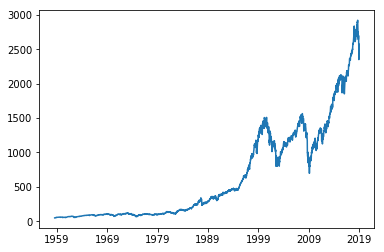

In [63]:
plt.plot(harvard_econ["timestep"], harvard_econ["S&P_Week"])

In [9]:
normalize = lambda data: [(i-np.min(data)) / np.std(data) for i in data]

In [10]:
def detrender(data, time):
    reg = LinearRegression().fit([[i] for i in time], data)
#     return reg.predict(np.reshape(time.tolist(), (-1, 1)))
    return [i-j for i, j in zip(data, reg.predict([[i] for i in time]))]

In [11]:
def plot_detrended_harvard_econ(cat1, cat2):
    plt.figure(figsize=(13.8, 8))
    plt.plot(harvard["timestep"], normalize(detrender(harvard[cat1], harvard["WeekID"])))
    plt.plot(econ_master["DATE"], normalize(econ_master[cat2]))
    plt.show()

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

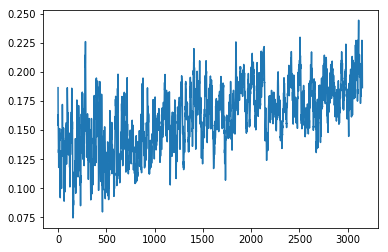

In [14]:
plt.plot(harvard["Negative_prop"])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


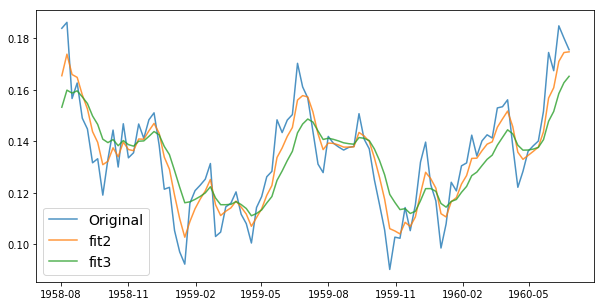

In [15]:
model = SimpleExpSmoothing(np.asarray(harvard['Negative_prop']))
model._index = pd.to_datetime(harvard.index)

fit1 = model.fit()
pred1 = fit1.forecast(9)
fit2 = model.fit(smoothing_level=.4)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.2)
pred3 = fit3.forecast(9)

plt.figure(figsize=(10, 5))
plt.plot(harvard["timestep"][:100], fit1.fittedvalues[:100], label = "Original", alpha=0.8)
plt.plot(harvard["timestep"][:100], fit2.fittedvalues[:100], label = "fit2", alpha=0.8)
plt.plot(harvard["timestep"][:100], fit3.fittedvalues[:100], label = "fit3", alpha=0.8)
plt.legend(fontsize=14)


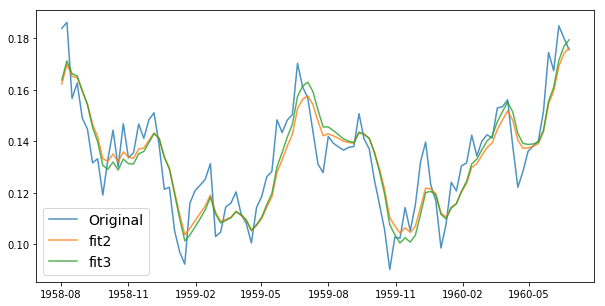

In [16]:
model = Holt(np.asarray(harvard['Negative_prop']))
model._index = pd.to_datetime(harvard["timestep"])


fit1 = model.fit(optimized=True)
fit2 = model.fit(smoothing_level=.3, smoothing_slope=.05)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.1)

harvard["Negative_prop_smoothed"] = fit3.fittedvalues

plt.figure(figsize=(10, 5))
plt.plot(harvard["timestep"][:100], fit1.fittedvalues[:100], label = "Original", alpha=0.8)
plt.plot(harvard["timestep"][:100], fit2.fittedvalues[:100], label = "fit2", alpha=0.8)
plt.plot(harvard["timestep"][:100], fit3.fittedvalues[:100], label = "fit3", alpha=0.8)
plt.legend(fontsize=14)


In [ ]:
plt.plot(train["timestep"], )

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [24]:
temp = [i-j for i, j in zip(econ_master.loc[1:econ_master.shape[0], "GDP_detrended"], econ_master.loc[:econ_master.shape[0]-1, "GDP_detrended"])]

In [25]:
temp = detrender(temp, econ_master.loc[1:, "WeekID"])

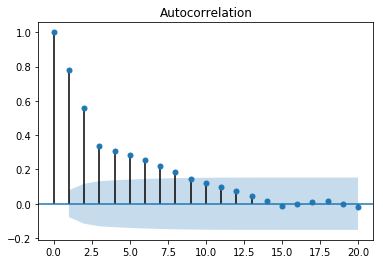

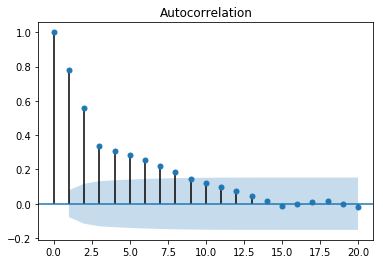

In [26]:
plot_acf(temp, lags=20)  

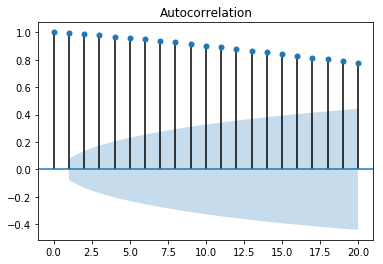

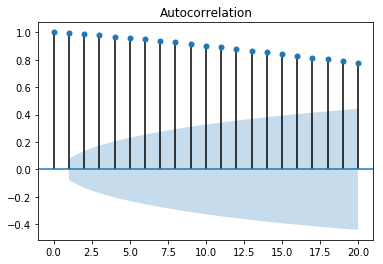

In [28]:
plot_acf(econ_master["GDP_detrended"], lags=20)              
            
                    

In [105]:
harvard.columns

Index(['timestep', 'Positive_prop', 'Negative_prop', 'Time_prop', 'Human_prop',
       'Object_prop', 'Knowledge_prop', 'Number_prop', 'Communication_prop',
       'Place_prop', 'Government_prop', 'Positive_cnts', 'Negative_cnts',
       'Time_cnts', 'Human_cnts', 'Object_cnts', 'Knowledge_cnts',
       'Number_cnts', 'Communication_cnts', 'Place_cnts', 'Government_cnts',
       'num_words', 'WeekID', 'Positive_prop_smoothed',
       'Negative_prop_smoothed'],
      dtype='object')

In [30]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(harvard["Negative_prop"].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(econ_master["GDP_detrended"].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(temp, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -5.033
P-value = 0.000
Critical values :
	1%: -3.4324416180141895 - The data is  stationary with 99% confidence
	5%: -2.862464147407348 - The data is  stationary with 95% confidence
	10%: -2.5672619455835424 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.231
P-value = 0.195
Critical values :
	1%: -3.4410979308822967 - The data is not stationary with 99% confidence
	5%: -2.8662819588823423 - The data is not stationary with 95% confidence
	10%: -2.5692953639629166 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -4.859
P-value = 0.000
Critical values :
	1%: -3.4410979308822967 - The data is  stationary with 99% confidence
	5%: -2.8662819588823423 - The data is  stationary with 95% confidence
	10%: -2.5692953639629166 - The data is  stationary with 90% confidence


In [16]:
def get_time_elapse_heatmap(df, time_gran, time_elapsed, start_year, end_year):
    temp = df.copy()
    temp[time_gran] = [i+time_elapsed for i in temp[time_gran]]
    corr_matrix = temp[(temp[time_gran] < end_year) & (temp[time_gran] >= start_year)].merge(econ_master[econ_categories + [time_gran]], left_on=time_gran, right_on=time_gran, how="inner").drop(time_gran, axis=1)
    plt.figure(figsize=(40,20))
    sns.set(font_scale=1)
    a=sns.heatmap(corr_matrix.corr(), annot=True, fmt="g",cmap='viridis')
    return corr_matrix

In [17]:
temp = harvard.merge(econ_master, left_on="WeekID", right_on="WeekID", how="left")
temp.head()

,timestep,Positive_prop,Negative_prop,Time_prop,Human_prop,Object_prop,Knowledge_prop,Number_prop,Communication_prop,Place_prop,Government_prop,Positive_cnts,Negative_cnts,Time_cnts,Human_cnts,Object_cnts,Knowledge_cnts,Number_cnts,Communication_cnts,Place_cnts,Government_cnts,num_words,WeekID,DATE,Food&Beverage,MonthID,GDP,Income,LoanRate,Meat,MedicalCare,Unemp,Food&Beverage_detrended,GDP_detrended,Income_detrended,LoanRate_detrended,Meat_detrended,MedicalCare_detrended,Unemp_detrended
0,1958-08-02,0.200191,0.186458,0.121920,0.129282,0.110238,0.014093,0.142720,0.028587,0.065694,0.000817,166.833333,126.0,92.333333,107.833333,76.0,12.0,129.0,23.0,49.000000,1.0,783.000000,-596,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1958-08-09,0.224297,0.154150,0.112234,0.128485,0.118590,0.023358,0.140357,0.030797,0.067730,0.000000,182.833333,120.0,90.333333,105.833333,81.0,16.0,127.0,25.0,53.666667,0.0,801.666667,-595,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1958-08-16,0.197232,0.163229,0.129134,0.114400,0.132131,0.019378,0.136217,0.028130,0.076363,0.003788,142.833333,118.0,91.333333,89.833333,79.0,15.0,102.0,21.0,53.000000,3.0,715.000000,-594,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1958-08-23,0.213554,0.147857,0.120359,0.129381,0.121195,0.019088,0.134265,0.035457,0.078843,0.000000,152.833333,106.0,86.333333,103.833333,80.0,15.0,105.0,26.0,59.000000,0.0,734.000000,-593,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1958-08-30,0.214669,0.144477,0.120517,0.118993,0.109327,0.020966,0.152390,0.034683,0.083979,0.000000,142.833333,102.0,83.333333,95.500000,74.0,15.0,104.5,23.0,58.000000,0.0,698.166667,-592,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
temp.columns

Index(['timestep', 'Positive_prop', 'Negative_prop', 'Time_prop', 'Human_prop',
       'Object_prop', 'Knowledge_prop', 'Number_prop', 'Communication_prop',
       'Place_prop', 'Government_prop', 'Positive_cnts', 'Negative_cnts',
       'Time_cnts', 'Human_cnts', 'Object_cnts', 'Knowledge_cnts',
       'Number_cnts', 'Communication_cnts', 'Place_cnts', 'Government_cnts',
       'num_words', 'WeekID', 'DATE', 'Food&Beverage', 'MonthID', 'GDP',
       'Income', 'LoanRate', 'Meat', 'MedicalCare', 'Unemp',
       'Food&Beverage_detrended', 'GDP_detrended', 'Income_detrended',
       'LoanRate_detrended', 'Meat_detrended', 'MedicalCare_detrended',
       'Unemp_detrended'],
      dtype='object')

In [19]:
for i in ['Food&Beverage_detrended', 'GDP_detrended', 'Income_detrended',
       'LoanRate_detrended', 'Meat_detrended', 'MedicalCare_detrended',
       'Unemp_detrended']:
    temp[i] = temp[i].interpolate("linear", limit_direction="both")
for i in ['Positive_prop', 'Negative_prop', 'Time_prop', 'Human_prop',
       'Object_prop', 'Knowledge_prop', 'Number_prop', 'Communication_prop',
       'Place_prop', 'Government_prop']:
    temp[i] = detrender(temp[i], temp["WeekID"])

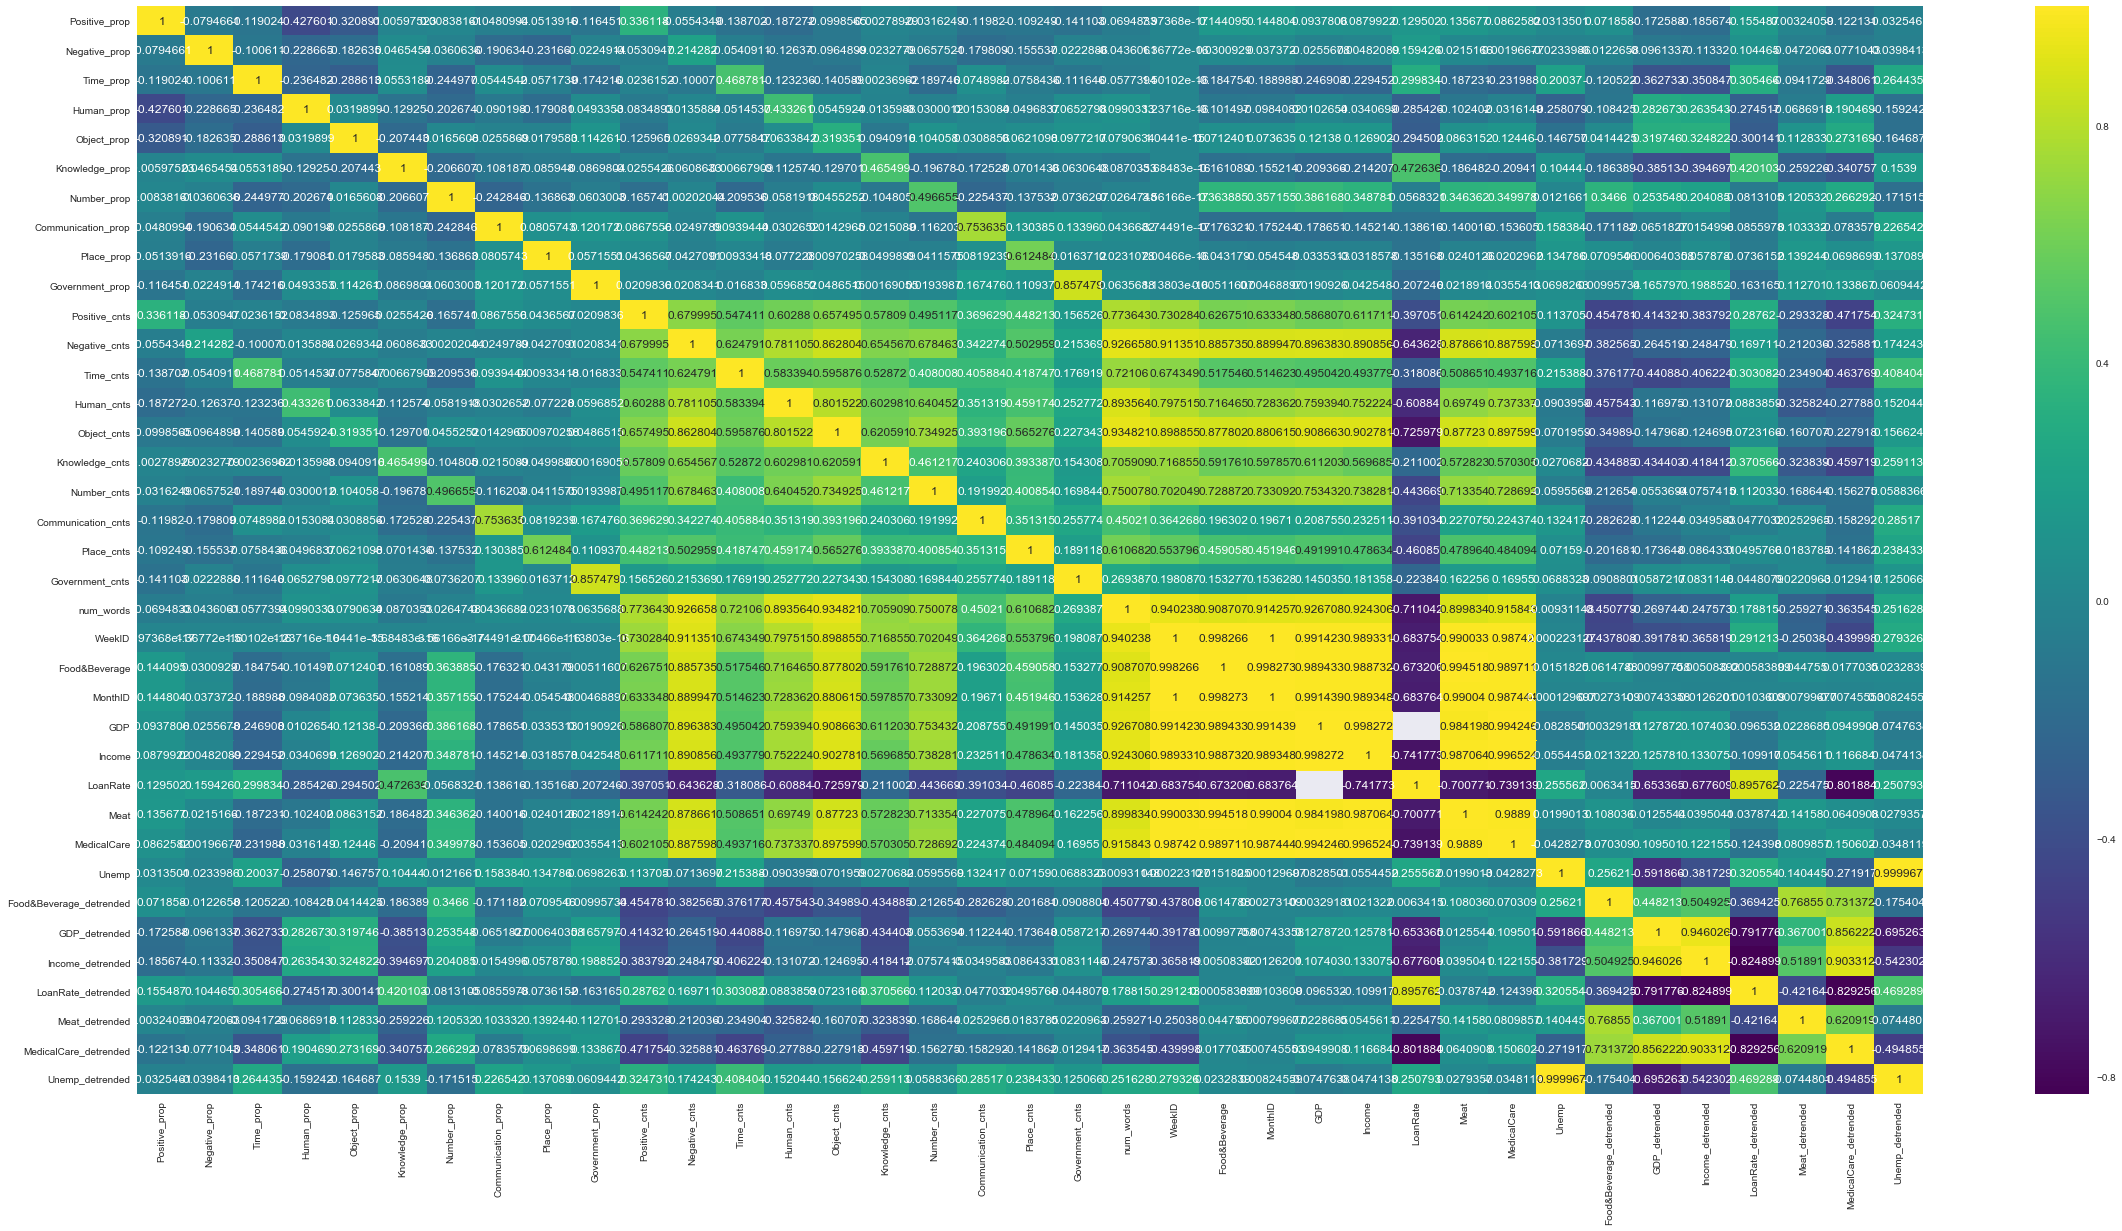

In [20]:
plt.figure(figsize=(40,20))
sns.set(font_scale=1)
a=sns.heatmap(temp.corr(), annot=True, fmt="g",cmap='viridis')